In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as transforms
from torchvision import datasets
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import time
import os

These are the corresponding imports to grab torch, functional, transforms, and matplot. Dataloader will help to import the images from folders.

In [ ]:
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(16)
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(32)
        self.conv3 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(64)
        self.conv4 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1)
        self.bn4 = nn.BatchNorm2d(128)
        self.conv5 = nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=1)
        self.bn5 = nn.BatchNorm2d(256)
        self.conv6 = nn.Conv2d(in_channels=256, out_channels=512, kernel_size=3, padding=1)
        self.bn6 = nn.BatchNorm2d(512)
        self.conv7 = nn.Conv2d(in_channels=512, out_channels=1024, kernel_size=3, padding=1)
        self.bn7 = nn.BatchNorm2d(1024)
        self.conv8 = nn.Conv2d(in_channels=1024, out_channels=2048, kernel_size=3, padding=1)
        self.bn8 = nn.BatchNorm2d(2048)

        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        
        self.fc1 = nn.Linear(2048 * 1 * 1, 4096)  #Adjust size
        self.fc2 = nn.Linear(4096, 3)
        
        self.dropout = nn.Dropout(0.3)  #Reduce if needed

    def forward(self, x):
        x = self.pool(F.relu(self.bn1(self.conv1(x))))
        x = self.pool(F.relu(self.bn2(self.conv2(x))))
        x = self.pool(F.relu(self.bn3(self.conv3(x))))
        x = self.pool(F.relu(self.bn4(self.conv4(x))))
        x = self.pool(F.relu(self.bn5(self.conv5(x))))
        x = self.pool(F.relu(self.bn6(self.conv6(x))))
        x = self.pool(F.relu(self.bn7(self.conv7(x))))
        x = self.pool(F.relu(self.bn8(self.conv8(x))))
        x = x.view(x.size(0), -1)  #Flattened for classes
        x = self.dropout(F.relu(self.fc1(x)))
        x = self.fc2(x)
        return x

In this block is the actual CNN. I created a simple CNN from nn.Module, and added 7 layers, each with batch normalization. Then, I did some max pooling, and changed the corresponding channls. Finally, it is flattened and converted into 7 outputs for the classes.

In [ ]:
transform_train = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.RandomHorizontalFlip(p=0.1),
    transforms.RandomRotation(10),
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),
    transforms.ColorJitter(brightness=0.5, contrast=0.5, saturation=0.5),
    transforms.RandomGrayscale(p=0.1),
    transforms.RandomPerspective(distortion_scale=0.5, p=0.1),
    transforms.ToTensor(),
    transforms.RandomErasing(p=0.2, scale=(0.02, 0.1)),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

#No augments here
transform_val = transforms.Compose([
    transforms.Resize((256, 256)), 
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

#Loading data
train_dataset = datasets.ImageFolder(root='MLDL_Data_Face-1/train', transform=transform_train)
val_dataset = datasets.ImageFolder(root='MLDL_Data_Face-1/val', transform=transform_val)

from sklearn.model_selection import StratifiedKFold
from torch.utils.data import Subset
import numpy as np

num_folds = 5

image_paths = np.array(train_dataset.imgs)
labels = np.array(train_dataset.targets)  

skf = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)

Here is where I import and transformed the data. I used multiple methods of transformation, but dataloader (then ImageFolder) is what gets the data. I assigned both datasets and got ready from there. I also specify number of folds for cross.

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Subset
from sklearn.model_selection import StratifiedKFold

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.backends.cudnn.benchmark = True 
class_counts = [4541, 5453, 4945]
class_weights = torch.FloatTensor([sum(class_counts) / count for count in class_counts]).to(device)

scaler = torch.amp.GradScaler('cuda') 

train_losses, val_losses, train_accuracies, val_accuracies = [], [], [], []

# Perform cross-validation
for fold, (train_idx, val_idx) in enumerate(skf.split(image_paths, labels)):
    print(f"Training on fold {fold + 1}/{num_folds}...")

    train_subset = Subset(train_dataset, train_idx)
    val_subset = Subset(train_dataset, val_idx)

    train_loader = DataLoader(train_subset, batch_size=32, shuffle=True)
    val_loader = DataLoader(val_subset, batch_size=32, shuffle=False)

    model = SimpleCNN().to(device)
    criterion = nn.CrossEntropyLoss(weight=class_weights)
    optimizer = optim.Adam(model.parameters(), lr=0.0001, weight_decay=1e-5)
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5)

    patience = 5
    best_val_loss = float('inf')
    counter = 0

    num_epochs = 50
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            
            with torch.amp.autocast('cuda'): 
                outputs = model(images)
                loss = criterion(outputs, labels)

            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()

            running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        train_loss = running_loss / len(train_loader)
        train_acc = 100 * correct / total

       
        model.eval()
        val_loss = 0.0
        correct = 0
        total = 0

        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)

                with torch.amp.autocast('cuda'):
                    outputs = model(images)
                    loss = criterion(outputs, labels)

                val_loss += loss.item()
                _, predicted = torch.max(outputs, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        val_loss /= len(val_loader)
        val_acc = 100 * correct / total

        print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%, "
              f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%")

        train_losses.append(train_loss)
        val_losses.append(val_loss)
        train_accuracies.append(train_acc)
        val_accuracies.append(val_acc)

    
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            counter = 0
        else:
            counter += 1
            if counter >= patience:
                print("Early stopping triggered.")
                break

        scheduler.step()


Training on fold 1/5...
Epoch [1/50], Train Loss: 0.9538, Train Acc: 52.62%, Val Loss: 0.7020, Val Acc: 68.31%
Epoch [2/50], Train Loss: 0.5271, Train Acc: 77.68%, Val Loss: 0.3877, Val Acc: 84.37%
Epoch [3/50], Train Loss: 0.3478, Train Acc: 86.21%, Val Loss: 0.3822, Val Acc: 85.74%
Epoch [4/50], Train Loss: 0.2744, Train Acc: 89.57%, Val Loss: 0.2188, Val Acc: 91.40%
Epoch [5/50], Train Loss: 0.2192, Train Acc: 91.69%, Val Loss: 0.2202, Val Acc: 91.47%
Epoch [6/50], Train Loss: 0.1419, Train Acc: 94.74%, Val Loss: 0.1272, Val Acc: 94.88%
Epoch [7/50], Train Loss: 0.1313, Train Acc: 95.10%, Val Loss: 0.1047, Val Acc: 96.35%
Epoch [8/50], Train Loss: 0.1167, Train Acc: 95.70%, Val Loss: 0.0950, Val Acc: 96.25%
Epoch [9/50], Train Loss: 0.1102, Train Acc: 95.94%, Val Loss: 0.1135, Val Acc: 95.31%
Epoch [10/50], Train Loss: 0.1074, Train Acc: 96.12%, Val Loss: 0.1770, Val Acc: 92.74%
Epoch [11/50], Train Loss: 0.0735, Train Acc: 97.34%, Val Loss: 0.0577, Val Acc: 97.76%
Epoch [12/50], Tr

This is the actual loop. It goes through each fold from cross and calculates the gradient, I used cross entropy loss function. There is also early stop just in case.

In [5]:
timestamp = time.strftime('%Y%m%d_%H%M%S')
checkpoint_filename = f'checkpoint_epoch_{epoch}_{timestamp}.pth'
torch.save({
    'epoch': epoch,
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'loss': val_loss,
}, checkpoint_filename)


In [6]:
""" checkpoint_path = 'checkpoint_epoch_1_20250320_171718.pth'
checkpoint = torch.load(checkpoint_path)
model.load_state_dict(checkpoint['model_state_dict'])
 """

" checkpoint_path = 'checkpoint_epoch_1_20250320_171718.pth'\ncheckpoint = torch.load(checkpoint_path)\nmodel.load_state_dict(checkpoint['model_state_dict'])\n "

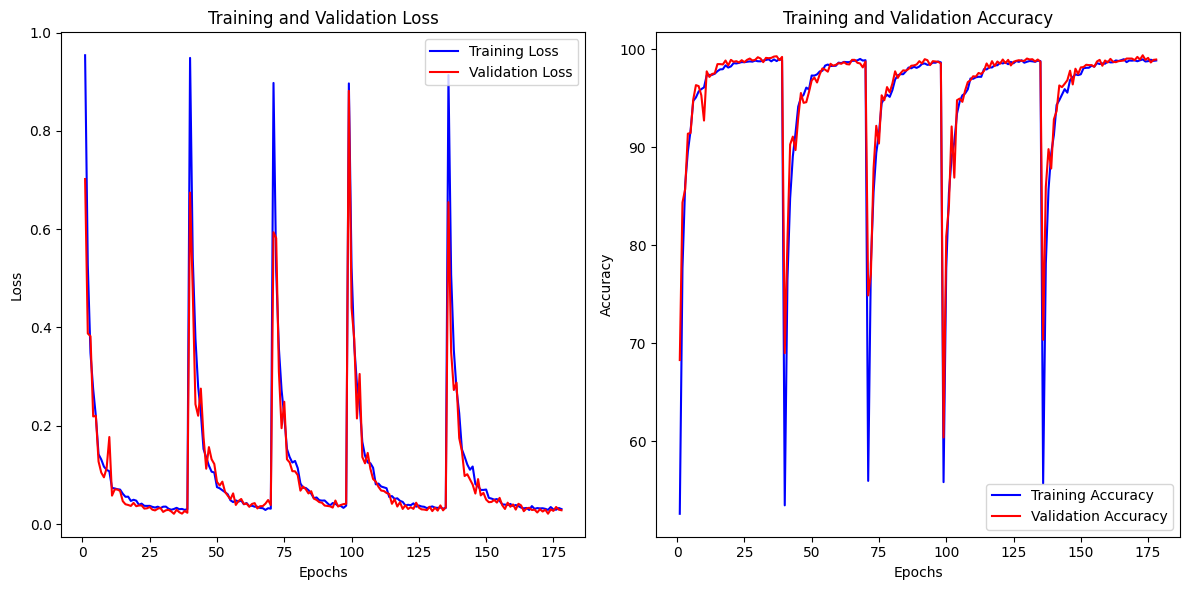

In [ ]:
import matplotlib.pyplot as plt

epochs = range(1, len(train_losses) + 1)

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(epochs, train_losses, label='Training Loss', color='blue')
plt.plot(epochs, val_losses, label='Validation Loss', color='red')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(epochs, train_accuracies, label='Training Accuracy', color='blue')
plt.plot(epochs, val_accuracies, label='Validation Accuracy', color='red')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.tight_layout()
plt.show()


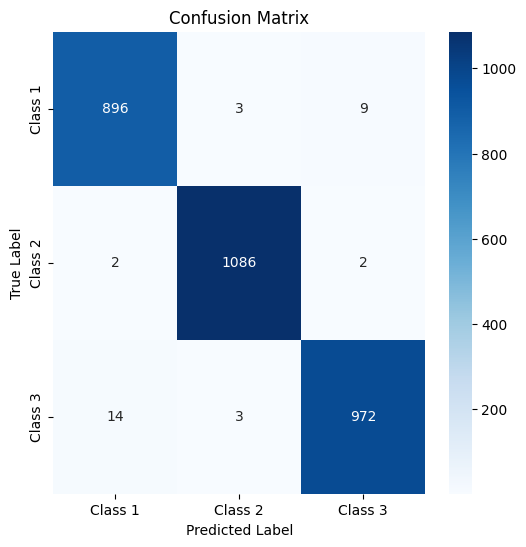

In [ ]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

model.eval()

all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in val_loader:  
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        
        all_preds.extend(predicted.cpu().numpy())  
        all_labels.extend(labels.cpu().numpy())  
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=train_dataset.classes, yticklabels=train_dataset.classes)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()
